<h1 style="text-align:center;">Project: Simulation of an ideal gas</h1>
<p style="text-align:center;">by Simon Legtenborg, 3773994</p>

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import random
import ipywidgets as widgets
from ipycanvas import Canvas, hold_canvas
from time import sleep
from threading import Thread
from scipy.optimize import curve_fit

<h2> Introduction </h2>

Einer der faszinierendsten Themen der Thermodynamik ist das Wechselspiel aus Marko- und Mikrophysik. Deswegen habe ich mir das Ziel gesetzt, eine Simulation zu entwickeln, die ein Gas auf mikroskopischer Ebene simuliert und makroskopische Zustände ausliest. Damit sollen die aus der Vorlesung bereits hergeleiteten Zustandsgleichungen (2. Gay-Lussac'sches Gesetz, Boyle-Mariotte'sches Gesetz, ideale Gasgleichung) überprüft und bestätigt werden. 
Die Arbeit bietet außerdem eine interaktive Simulation.

<h2>Fundamentals</h2>

Bevor wir zur Simulation kommen, müssen die Gesetzmäßigkeiten erklärt werden, die wir im Anschluss überprüfen wollen.

<h3>Zustandsgleichungen</h3>

In der Simulation kann Volumen, Temperatur und Teilchenzahl variiert bzw. konstant gehalten werden. Es bietet sich deshalb an, die Gesetze von Boyle-Marionette und Gay-Lussac (2. Gesetz) zu überprüfen:

<b>Boyle-Marionette: </b>Wird eine feste Menge (N) eines idealen Gases auf einer konstanten Temperaur (T) gehalten, während Druck (p) und Volumen (V) veränderbar sind, so ist das Volumen indirekt proportional
zum Druck. Es gilt:<br>
$N,T \hbox{ konst.} \Rightarrow V \propto \frac{1}{p}$

<b>2. Gay-Lussac'sches Gesetz: </b>Wird eine feste Menge (N) eines idealen Gases auf einem konstanten Volumen (V) gehalten, während sich die Temperatur (T) oder der Druck (p) ändern, so ist der Druck proportional zur Temperatur (T). Es gilt:<br>
$N, V \hbox{ konst. } \Rightarrow p \propto T$

Für eine feste Menge eines idealen Gases gilt nun: <br>

<ol>
    <li>$p \propto \frac{1}{V}\;\;$ für festes T</li>
    <li>$p \propto T\;\;$ für festes V</li>
</ol>

Daraus folgt: <br>
$p \propto \frac{T}{V} \Rightarrow \frac{p \cdot V}{T}=konst.$

Wird anschließend noch die Teilchenzahl variiert, so ergibt sich die ideale Gasgleichung: <br>
$p \cdot V = N \cdot k_B \cdot T$



<b>Zusammenfassen von Proportionalitäten: </b> Um die ideale Gasgleichung zu zeigen, reicht es, folgende Gleichungen zu zeigen:
<ol>
    <li>     $p \propto \frac{1}{V}$ für festes N, T</li>
    <li>     $p \propto T$ für festes N, V</li>
    <li>     $p \propto N$ für festes T, V </li>
</ol>

Beweis:
Die drei Gleichungen implizieren $\forall$T,N,V:
<ol>
    <li>     $p=k_1(T,N) \cdot \frac{1}{V}$</li>
    <li>     $p=k_2(V,N) \cdot T$</li>
    <li>     $p=k_3(V,T) \cdot N$</li>
</ol>

Setzen wir nun 1. mit 2. gleich, dann gilt:<br>

$
\begin{align*}
    &k_1(T,N) \cdot \frac{1}{V}=k_2(V,N) \cdot T\\
    &\Rightarrow \frac{k_1(T,N)}{T}=k_2(V,N) \cdot V \stackrel{!}{=} K(N)\\
    &\Rightarrow k_2(V,N)=\frac{K(N)}{V}\\
    &\Rightarrow p(V,T,N) = K(N) \cdot \frac{T}{V}
\end{align*}
$<br>

Nun setzen wir unsere neu erhaltene Gleichung mit Gleichung 3. gleich, dann gilt:<br>

$
\begin{align*}
    &K(N) \cdot \frac{T}{V}=k_3(V,T) \cdot N\\
    &\Rightarrow \frac{K(N)}{N}=k_3(V,T) \cdot \frac{V}{T} \stackrel{!}{=} k_B\\
    &\Rightarrow k_3(V,T) = k_B \cdot \frac{T}{V}\\
    &\Rightarrow p(V,T,N) = k_B \cdot \frac{T}{V} \cdot N = N \cdot k_b \cdot \frac{T}{V}
\end{align*}
$<br>

<h3> Das Modell des idealen Gases </h3>

Die oben beschriebenen Gesetze setzen voraus, dass mit einem idealen Gas gearbeitet wird. Infolgedessen erläutere ich, was ein ideales Gas ist und wie es simuliert werden kann.

Folgende Annahmen beschreiben das Modell des idealen Gases vollständig:

<ul>
    <li>Atome/Moleküle werden durch kleine starre Kugeln mit Radius approximiert</li>
    <li>N Kugeln existieren in einer Box; Position, Geschwindigkeit, Masse und Radius sind gekannt</li>
    <li>Geschwindigkeit ist statistisch verteilt </li>
    <li>Kugeln interagieren nur durch elastische Stöße mit der Wand oder anderen Teilchen</li>
    <li>Kugelradius ist klein gegenüber dem mittleren Abstand der Teilchen
</ul>

<table>
  <tr>
    <td style="background-color:white">
        <figure>
          <img src="images/video1.gif" alt="WallBounce" style="width:100%">
          <figcaption>elastischer Stoß zwischen Kugel und Wand</figcaption>
        </figure>
    </td>
    <td style="background-color:white">
        <figure>
          <img src="images/video2.gif" alt="Bounce" style="width:100%">
          <figcaption>elastischer Stoß zwischen zwei Kugeln</figcaption>
        </figure>
    </td>
  </tr>
</table>

<h3>Die Mathematik der Stöße</h3>

Stöße sind die einzige Möglichkeit, wie Teilchen miteinander interagieren können. Deswegen ist dies auch der Schwerpunkt der Simulation.

<b>Die Mathematik von elastischen Stößen in 1D: </b>Beim idealen elastischen Stoß stoßen zwei Körper aufeinander, ohne das kinetische Energie verloren geht. Es gilt also der Energie- und Impulserhaltungssatz:<br><br>
$
\begin{align*}
   &\sum E_{kin}=\sum E_{kin}'\\
   &\frac{m_1}{2} \cdot v_1^2+\frac{m_2}{2} \cdot v_2^2 = \frac{m_1}{2} \cdot {v_1'}^2
   + \frac{m_2}{2} \cdot {v_2'}^2\\
   &\frac{m_1}{2} \cdot (v_1^2-{v_1'}^2)=\frac{m_2}{2} \cdot ({v_2'}^2-v_2^2)\\\\
   &\sum \vec{p}= \sum \vec{p'}\\
   &m_1 \cdot \vec{v_1}+m_2 \cdot \vec{v_2} = m_1 \cdot \vec{v_1'}
   + m_2 \cdot \vec{v_2'}\\
   &m_1 \cdot (\vec{v_1}-\vec{v_1'})=m_2 \cdot (\vec{v_2'}-\vec{v_2})\\
\end{align*}
$<br><br>

Durch geeignetes Umstellen (siehe Demtröder) ergibt sich für $v_1'$ und $v_2'$:<br>
    
$
\begin{align*}
    &v_1'=2 \frac{m_1 v_1+m_2 v_2}{m_1 + m_2}-v_1\\
    &v_2'=2 \frac{m_1 v_1+m_2v_2}{m_1+m_2}-v_2
\end{align*}
$
 
    
Für den Fall $m_2 \to \infty$ und $v_2=0$, also eine Wand, gilt:<br>
$
\begin{align*}
    &v_1'=-v_1\\
    &v_2'=0
\end{align*}
$

<b>Die Mathematik von Stößen in 2D:</b> Der zweidimensionale elastische Stoß beruht prinzipiell auf dem eindimensionalen Stoß. Für die Berechnung benötigen wir ein geeignetes Koordinatensystem, welches eine Achse senkrecht und eine Achse parallel zur Zentralsteigung besitzt. Die Zentralsteigung beschreibt hierbei die Gerade durch die Mittelpunkte der Kugeln. Beim Stoß erfolgt die Berechnung wie beim eindimensionalen, aber nur in Richtung der Zentralsteigung.<br>
    
<figure style="float:left;">
    <img src="./images/asset6.svg", width=300px style="margin:10px">
    <figcaption>Stoß in 2D</figcaption>
</figure>

<p>
    Für den elastischen Stoß gilt dann:<br>
        $
        \begin{align*}
            &\vec{v_1} =
            \begin{pmatrix}
                v_{1x}\\
                v_{1y}
            \end{pmatrix},
            \vec{v_2} =
            \begin{pmatrix}
                v_{2x}\\
                v_{2y}
            \end{pmatrix}\\
            &\vec{v_1'}=
            \begin{pmatrix}
                2 \frac{m_1 v_{1x}+m_2 v_{2x}}{m_1 + m_2}-v_{1x}\\
                v_{1y}
            \end{pmatrix}\\
            &\vec{v_2'}=
            \begin{pmatrix}
                2 \frac{m_1 v_{1x}+m_2 v_{2x}}{m_1 + m_2}-v_{2x}\\
                v_{2y}
            \end{pmatrix}
        \end{align*}
        $
</p>
    
    


    

<b>Koordinatentransformation: </b> Die wichtigste Voraussetzung für die Berechnung zweidimensionaler Stöße ist ein geeignete Koordinatensystem, welches nicht trivial gegeben ist. Für die Simulation wird die kanonische Basis verwendet. Um auf unser neues Koordinatensystem zu kommen, nutzen wir eine Basistransformationsmatrix U. Da U  ein gedrehtes kanonisches Koordinatensystem ist, kann man die Transformationsmatrix als Drehmatrix auffassen.

<figure style="float:left;">
    <img src="./images/asset7.svg" width=300px style="margin:10px">
    <figcaption>Rotiertes Koordinatensystem</figcaption>
</figure>

<p>
$
\begin{align*}
    &U_{\alpha} = 
    \begin{pmatrix}
        &\cos(\alpha) &-\sin(\alpha)\\
        &\sin(\alpha) & \cos(\alpha)
    \end{pmatrix}
\end{align*}
$<br>

Möchte man von der neuen Basis zurück in die kanonische gelangen, so berechnet man die inverse Matrix. Für die Rotationsmatrix gilt dann:<br>
$
\begin{align*}
    &U_{\alpha}^{-1} = 
    \begin{pmatrix}
        &\cos(-\alpha) &-\sin(-\alpha)\\
        &\sin(-\alpha) & \cos(-\alpha)
    \end{pmatrix}
\end{align*}
$<br>

Ausschlaggebend für die Berechnung der Rotationsmatrix ist der Winkel $\alpha$. Dieser kann über die atan2-Funktion berechnet werden:<br>
$
\begin{align*}
    &\alpha = \arctan2(dy,dx) \\
\end{align*}
$<br>
Dies ist alles was man für die Berechnung an Grundwissen benötigt.
</p>

<h3>Gleichungen der kinetischen Gasthorie</h3>

<h2>Results and Discussion</h2>

Nun ist die nötige Theorie bekannt, um die Simulation eines idealen Gases zu programmieren. Diese besteht aus zwei Klassen. Zum einen die <i>particle</i> und zum anderen die <i>simulation</i> Klasse. Im Folgenden werden die Klassen kurz beschrieben:

<h3>particle class</h3>
Die Klasse Partikel dient dazu, die Eigenschaften und Methoden eines Partikels festzuhalten.

<b>Die Klasse besitzt folgende Eigenschaften: </b>

<ul>
    <li>Masse m (kg)</li>
    <li>Position p (m)</li>
    <li>Grundgeschwindigkeit v (m/s) </li>
    <li>Kugelradius r (m) </li>
    <li>Ratio</li>
</ul>

Die ersten vier Eigenschaften sind selbsterklärend. Die fünfte Eigenschaft beschreibt den Anteil der Grundgeschwindigkeit v, die die Partikel haben.

<b>Die Klasse besitzt folgende Methoden: </b>

<ul>
    <li><i>move</i> Bewegt das Teilchen entsprechend des Zeitintervalls dt und seiner Geschwindigkeit v</li>
    <li><i>bounceWall</i> Korrigiert Geschwindigkeit und Position, falls sich ein Teilchen mit einer Wand überschneidet</li>
    <li><i>bounce</i> Korrigiert Geschwindigkeit und Position, falls zwei Teilchen kollidieren</li>
    <li><i>getKineticEnergy</i> liefert die kinetische Energie des Teilchens</li>
</ul>

In [34]:
class particle:
    
    def rotMat(alpha, x):
        return np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]]).dot(x)
    
    def __init__(self, m, x,y, vx, vy,r, color):
        self.m = m     #kg
        self.vx = vx   #m/s
        self.vy = vy   #m/s
        self.x = x     #m
        self.y = y     #m
        self.r = r     #m
        self.ratio = 1
        self.color = color
    
    def move(self, dt, ratio):
            self.x = self.vx * ratio * dt+ self.x
            self.y = self.vy * ratio * dt + self.y
            self.ratio = ratio
            
    def bounceWall(self,n):
        match n:
            case 0:
                self.vx = -self.vx
                self.x = 2*self.r - self.x
            case 1:
                self.vx = -self.vx
                self.x= 2*(simulation.width.value*10**-12-self.r)-self.x
            case 2:
                self.vy = -self.vy
                self.y = 2*self.r-self.y
            case 3:
                self.vy = -self.vy
                self.y = 2*(simulation.height-self.r)-self.y
                
    def bounce(self,p):
        dx = self.x-p.x
        dy = -(self.y-p.y)
        d = np.sqrt(dx**2+dy**2)
        alpha = np.arctan2(dy,dx)
        
        p1=np.array([self.x,self.y])
        p2=np.array([p.x,p.y])
        p1s=particle.rotMat(alpha,p1)
        p2s=particle.rotMat(alpha,p2)
        p1ns=np.array([p1s[0]+(self.r+p.r-d)/2,p1s[1]])
        p2ns=np.array([p2s[0]-(self.r+p.r-d)/2,p2s[1]])
        p1n=particle.rotMat(-alpha,p1ns)
        p2n=particle.rotMat(-alpha,p2ns)
        self.x=p1n[0]
        self.y=p1n[1]
        p.x=p2n[0]
        p.y=p2n[1]
         
        v1 = np.array([self.vx, self.vy])
        v2 = np.array([p.vx, p.vy])
        v1s = particle.rotMat(alpha,v1)
        v2s = particle.rotMat(alpha,v2)
        v1ns=(2*(self.m*v1s[0]+p.m*v2s[0])/(self.m+p.m)-v1s[0],v1s[1])
        v2ns=(2*(self.m*v1s[0]+p.m*v2s[0])/(self.m+p.m)-v2s[0],v2s[1])
        v1n= particle.rotMat(-alpha,v1ns)
        v2n= particle.rotMat(-alpha,v2ns)
        self.vx = v1n[0]
        self.vy = v1n[1]
        p.vx = v2n[0]
        p.vy = v2n[1]
        
    def getKineticEnergy(self,dt):
        return 1/2 * self.m * ((self.vx*self.ratio)**2+(self.vy*self.ratio)**2)

<h3>simulation class</h3>
Diese Klasse dient dazu, Stöße zu registrieren, Partikel zu bewegen und zu visualisieren sowie statistische Größen (Temperatur, Druck, Volumen) auszugeben.

<b>Die Klasse besitzt folgende Eigenschaften: </b>

<ul>
    <li><i>p </i> Array indem alle Teilchen gespeichert sind</li>
    <li><i>startSimulation </i> Die Simulation läuft so lange, bis startSimulation=false</li>
    <li><i>height </i>Höhe der Box</li>
    <li><i>width </i>Weite der Box (als IntSlider Objekt)</li>
    <li><i>veloRatio </i>Ratio aller Teilchen (als FloatSlider Objekt)</li>
    <li><i>dt </i> Zeitintervall für Simulation</li>
    <li><i>radius </i>Radius für die generierten Kugeln</li>
    <li><i>mass </i>Masse der generierten Kugeln </li>
    <li><i>k </i>Boltzmann constant</li>
    <li><i>t </i>Gesamtzeit</li>
    <li><i>E_kin </i>Gesamtenergie der Teilchen</li>
    <li><i>impulse </i>Array für aufgezeichnete Impulse</li>
    <li><i>buttonAdd/buttonRem </i> Knöpfe um Teilchen hinzuzufügen/zu entfernen</li>
    <li><i>buttonStart/buttonStop </i>Knöpfe um Simulation zu starten/stoppen</li>
    <li><i>textVolume/textPressure/textTemperature/textParticles </i>Ausgabe Werte (als FloatText)</li>
</ul>


<b>Die Klasse besitzt folgende Methoden: </b>

<ul>
    <li><i>generateParticles </i>generiert n Partikel mit zufälliger Position und zufälliger Geschwindigkeit</li>
    <li><i>generateParticlesUniformly</i> generiert n Partikel mit zufälliger Position und zufälliger Geschwindigkeitsrichtung, aber festem Geschwindigkeitsbetrag</li>
    <li><i>removeParticles </i>entfernt die letzten n Partikel</li>
    <li><i>deleteParticles </i>entfernt alle Partikel</li>
    <li><i>addParticle </i>fügt ein neues Partikel hinzu</li>
    <li><i>reset </i>setzt Werte der Simulation zurück</li>
    <li><i>animateParticles </i>  berechnet und animiert Simulation. Wird nur als Thread aufgerufen</li>
    <li><i>collisionTest </i> Überprüft, ob Partikel kollidiert sind und korrigiert Laufbahn. Nimmt Werte für Druck und Temperaturausgabe auf</li>
    <li><i>updateValue</i> Updates volume, pressure, temperature and time</li>
    <li>initialize <i></i>starts animateParticles Thread and display canvas</li>
    <li>start <i></i>starts animateParticles Thread</li>
    <li><i>stop </i> stops animateParticles Thread</li>
    <li><i>interactive </i> starts the interactive simulation</li>
    
    
    
</ul>

In [30]:
class simulation:
    
    p = []
    startSimulation=False
    
    height = 3000e-12        #m (3000pm)
    width = widgets.IntSlider(min=500, max= 10000, value=10000, description="Width (pm) ")
    veloRatio = widgets.FloatSlider(min=0.1,max=2, value=1,step=0.01, description="Velocity (%)")

    dt = 20e-15              #s (20fs)
    radius = 30e-12          #m (20pm)
    mass = 2.6569e-26        #kg
    k = 1.380649 *10**-23    #J/K
    
    t = 0
    E_kin = 0
    impulse = np.zeros(50)
    
    
    buttonAdd = widgets.Button(description="+")
    buttonRem = widgets.Button(description="-")
    buttonStart = widgets.Button(description="start")
    buttonStop = widgets.Button(description="stop")
    
    textVolume = widgets.FloatText(description="Volume (pm³)", disabled=True)
    textPressure = widgets.FloatText(description="Press. (Pa)", disabled=True)
    textTemperature = widgets.FloatText(description="Temp. (K)", disabled=True)
    textParticles = widgets.IntText(disabled = True)
    
    canvas = Canvas(width = width.max/10, height=height*10**12/10)
    
    def generateParticles(button=widgets.Button(), n=10):
        for _ in range(n):
            v = random.randint(0,2000)
            alpha = random.random() * 2 * np.pi
            simulation.p.append(particle(
                simulation.mass,
                random.randint(0,simulation.width.value)*10**-12,
                random.randint(0,simulation.height*10**12)*10**-12,
                v * np.cos(alpha),
                v * np.sin(alpha),
                simulation.radius,
                "black"))
            simulation.textParticles.value = len(simulation.p)
                
            
    def generateParticlesUniformly(n=10, v = 1000):
        for _ in range(n):
            alpha = random.random() * 2 * np.pi
            simulation.p.append(particle(
                2.6569e-26,
                random.randint(0,simulation.width.value)*10**-12,
                random.randint(0,simulation.height*10**12)*10**-12,
                v * np.cos(alpha),
                v * np.sin(alpha),
                simulation.radius,
                "black"))
            simulation.textParticles.value = len(simulation.p)
    
    def removeParticles(button=widgets.Button(), n=10):
            for _ in range(n):
                if simulation.p:
                    simulation.p.pop()
            simulation.textParticles.value = len(simulation.p)

    def deleteParticles():
        simulation.p = []
    
    def addParticle(particle):
        simulation.p.append(particle)
    
    def reset():
        simulation.width.value=4000
        simulation.veloRatio.value=1
        simulation.impulse = np.zeros(50)
        simulation.t = 0
        simulation.deleteParticles()
        simulation.stop()
                        
    def animateParticles():     #1px = 10pm
        while simulation.startSimulation:
            with hold_canvas():
                simulation.canvas.clear()
                simulation.canvas.stroke_rect(0,0,width=simulation.width.value/10,height=simulation.height*10**12/10)
                for i in simulation.p:
                    simulation.canvas.fill_style = i.color
                    simulation.canvas.fill_circle(i.x*10**12/10, i.y*10**12/10, i.r*10**12/10)
                    i.move(simulation.dt, simulation.veloRatio.value)
            
            simulation.collisionTest()
            simulation.updateValues()
            sleep(simulation.dt*10**12)
            
    def collisionTest():
        count = 1
        for i in simulation.p:
            for j in simulation.p[count::]:
                dx = j.x-i.x
                dy = j.y-i.y
                if dx**2+dy**2 < (i.r+j.r)**2:
                     if (dx*i.vx <=0 and dx*j.vx >=0 ) and (dy*i.vy <=0 and dy*j.vy >=0 ):
                        pass 
                     else:
                        i.bounce(j)
            count = count + 1
            
            if i.x < i.r:
                i.bounceWall(0)
                simulation.impulse[0] = simulation.impulse[0] + abs(2 * i.m * i.vx * i.ratio)
            elif i.x > simulation.width.value*10**-12-i.r:
                i.bounceWall(1)
                simulation.impulse[0] = simulation.impulse[0] + abs(2 * i.m * i.vx * i.ratio)
                
            if i.y < i.r:
                i.bounceWall(2)
                simulation.impulse[0] = simulation.impulse[0] + abs(2 * i.m * i.vy * i.ratio)
            elif i.y > simulation.height-i.r:
                i.bounceWall(3)
                simulation.impulse[0] = simulation.impulse[0] + abs(2 * i.m * i.vy * i.ratio)
            
            simulation.E_kin = simulation.E_kin + i.getKineticEnergy(simulation.dt)

        
    def updateValues():
        simulation.textVolume.value=simulation.width.value*10**(-12) * simulation.height * 2 *simulation.radius
        simulation.textPressure.value = np.mean(simulation.impulse)/(simulation.dt * 4 *simulation.radius *(simulation.width.value*10**(-12) +simulation.height))
        simulation.impulse = np.roll(simulation.impulse,1)
        simulation.impulse[0] = 0
        simulation.t = simulation.t+ simulation.dt
        if simulation.p:
            simulation.E_kin = simulation.E_kin/len(simulation.p)
            simulation.textTemperature.value= simulation.E_kin/simulation.k
        simulation.E_kin = 0
        
    def initialize():
        simulation.startSimulation=False
        display(simulation.canvas)
        simulation.start()
        
            
    def start(button=widgets.Button()):
        simulation.startSimulation = True
        t = Thread(target=simulation.animateParticles, daemon=True)
        t.start()
        
    def stop(button=widgets.Button()):
        simulation.startSimulation = False
        
        
    def interactive():
        simulation.startSimulation=False
        simulation.buttonAdd.on_click(simulation.generateParticles)
        simulation.buttonRem.on_click(simulation.removeParticles)
        simulation.buttonStart.on_click(simulation.start)
        simulation.buttonStop.on_click(simulation.stop)

        items = [widgets.HBox([simulation.buttonAdd, simulation.buttonRem, simulation.textParticles]),
                 simulation.textVolume, simulation.buttonStart, 
                 simulation.width, simulation.textPressure, simulation.buttonStop, 
                 simulation.veloRatio, simulation.textTemperature]
        w = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(3, 300px)"))

        display(w)
        display(simulation.canvas)

         

<h3>Grundannahmen</h3>

<h4>statistische Verteilung der Geschwindigkeit: </h4>

Eine wichtige Voraussetzung für ein ideales Gas ist die Isotropie der Geschwindigkeitsverteilung. Diese wird nun überprüft.

Es werden 200 Partikel generiert und deren Geschwindigkeit in zwei Arrays gespeichert. Anschließend werden die quadratisch gemittelte Gesamtgeschwindigkeit und die quadratisch gemittelten Geschwindigkeiten in x und y Richtung gebildet. 

In [75]:
simulation.reset()
simulation.generateParticles(n=200)
vx = np.array([])
vy = np.array([])
for i in simulation.p:
    vx = np.append(vx, i.vx)
    vy = np.append(vy, i.vy)
    
v_mean = np.mean(np.sqrt(vx**2+vy**2))

v_squared_mean = np.mean(vx**2+vy**2)
vx_squared_mean = np.mean(vx**2)
vy_squared_mean = np.mean(vy**2)

Schauen wir uns die Werte an:

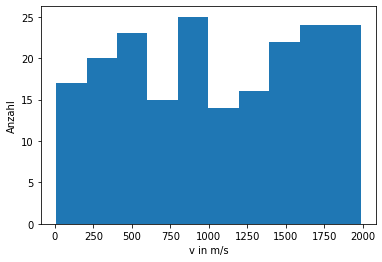

mittlere Geschwindigkeit: 1032.54 m/s
quadratisch gemittelte Geschindigkeit: 1410528.05 m²/s²
quadratisch gemittelte Geschwindigkeit in x-Richtung: 720408.6315376902 m²/s²
quadratisch gemittelte Geschwindigkeit in y-Richtung: 690119.41846231 m²/s²


In [76]:
plt.xlabel("v in m/s")
plt.ylabel("Anzahl")
plt.hist(np.sqrt(vx**2+vy**2),10)
plt.show()

print(f"mittlere Geschwindigkeit: {v_mean} m/s")
print(f"quadratisch gemittelte Geschindigkeit: {v_squared_mean} m²/s²")
print(f"quadratisch gemittelte Geschwindigkeit in x-Richtung: {vx_squared_mean} m²/s²")
print(f"quadratisch gemittelte Geschwindigkeit in y-Richtung: {vy_squared_mean} m²/s²" )

Wir erkennen, dass folgende Beziehungen gelten: <br>

$
\begin{align}
    \overline{{v_x}^2} \approx \frac{1}{2} \cdot \overline{v²} \\
    \overline{{v_y}^2} \approx \frac{1}{2} \cdot \overline{v²}
\end {align}
$ <br>

Die Geschwindigkeitsverteilung ist somit isotrop.

<h4>Stöße</h4>

Jetzt ist es an der Zeit, die Stöße zu testen. Führe dafür zuerst <i>simulation.show()</i> aus und dann das gewünschte Preset.

In [77]:
simulation.reset()
simulation.initialize()

Canvas(height=300, width=1000)

<b>Preset 1 - Testkollision mit der Wand</b>

In [78]:
simulation.deleteParticles()
simulation.addParticle(particle(1,500*10**-12,500*10**-12,1000,1000,30*10**-12,"black"))

<b>Preset 2 - Horizontaler Stoß</b>

In [79]:
simulation.deleteParticles()
simulation.addParticle(particle(1,250*10**-12,1500*10**-12,1000,0,30*10**-12,"blue"))
simulation.addParticle(particle(1,600*10**-12,1500*10**-12,-500,0,30*10**-12,"red"))

<b>Preset 3 - vertikaler Stoß<br>

In [80]:
simulation.deleteParticles()
simulation.addParticle(particle(20,2000*10**-12,1000*10**-12,0,-500,60*10**-12,"blue"))
simulation.addParticle(particle(1,2000*10**-12,2000*10**-12,0,200,30*10**-12,"red"))

<b>Preset 4 - schiefer Stoß</b>

In [81]:
simulation.deleteParticles()
simulation.addParticle(particle(1,250*10**-12,1500*10**-12,1000,0,30*10**-12,"blue"))
simulation.addParticle(particle(1,2000*10**-12,1510*10**-12,-500,0,30*10**-12,"red"))

<b>Preset 5 - Billard Stoß </b>

In [82]:
simulation.deleteParticles()
simulation.addParticle(particle(1,250*10**-12,1500*10**-12,1000,0,30*10**-12,"blue"))
simulation.addParticle(particle(1,2500*10**-12,1500*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2560*10**-12,1470*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2560*10**-12,1530*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2620*10**-12,1500*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2620*10**-12,1440*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2620*10**-12,1560*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2680*10**-12,1530*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2680*10**-12,1590*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2680*10**-12,1470*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2680*10**-12,1410*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2740*10**-12,1500*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2740*10**-12,1560*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2740*10**-12,1620*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2740*10**-12,1440*10**-12,0,0,30*10**-12,"black"))
simulation.addParticle(particle(1,2740*10**-12,1380*10**-12,0,0,30*10**-12,"black"))

<b>Preset 6 - Your Choice</b>

In [ ]:
simulation.deleteParticles()
#add your code here. Feel free to explore

<h3>Herleitung fundamentaler Zusammenhänge</h3>

Jetzt kommen wir zur Herleitung der idealen Gasgleichung. Dazu zeigen wir zunächst das Gesetz von Boyle-Marionette.

<h4>Boyle-Marionette</h4>

Um das Gesetz von Boyle-Marionette numerisch zu beweisen, generieren wir zuerst 200 Partikel und starten die Simulation. Während wir aller 3 Sekunden das Volumen unserer Box verkleinern, werden in zwei Arrays Volumen und Druck gemessen und aufgezeichnet. Dabei ist die Temperatur konstant. Anschließend werden die Daten als Scatterplot ausgegeben, um einen möglichen Zusammenhang festzustellen.

Canvas(height=300, width=1000)

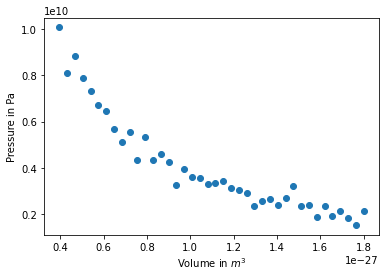

In [87]:
simulation.reset()
simulation.width.value=10000
simulation.generateParticles(n=200)

volume = np.array([])
pressure = np.array([])

w = widgets.HBox([simulation.textPressure, simulation.textTemperature, simulation.textVolume])
display(w)
simulation.initialize()


for i in range(0,8000,200):
    simulation.width.value=10000-i
    sleep(3)
    volume=np.append(volume, simulation.width.value*10**-12*simulation.height*2*simulation.radius)
    pressure=np.append(pressure, simulation.textPressure.value)

simulation.stop()
plt.scatter(volume,pressure)
plt.xlabel(f"Volume in $m^3$")
plt.ylabel(f"Pressure in Pa")
plt.show()

Der gezeigte Plot sieht eindeutig nach einer Hyperbel aus. Dann muss gelten: $p=\frac{k(T,N)}{V}$. Um unsere Hypothese zu verifizieren, führen wir eine Regression aus. 

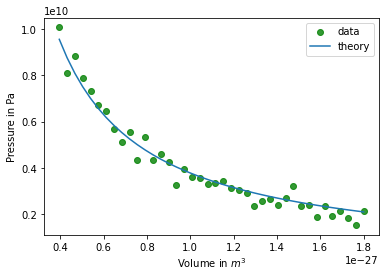

k = [3.78336069e-18]


In [88]:
def hyperbola(x,k):
    return k/x

k, cov =curve_fit(hyperbola,volume,pressure,p0=10**-18,absolute_sigma=True)
plt.scatter(volume, pressure, color="green", label="data", alpha=0.8)
plt.plot(volume, hyperbola(volume, k),color="tab:blue", label="theory")
plt.legend()
plt.xlabel(f"Volume in $m^3$")
plt.ylabel(f"Pressure in Pa")
plt.show()
print(f"k = {k}")

Wir halten fest, dass es sich hier um einen hyperbolischen Zusammenhang handelt. Mathematisch bedeutet das:<br>

$\begin{align*}
    &p = \frac{k(T,N)}{V}\\
    \Rightarrow &V = \frac{k_1(T,N)}{p}\\
    \Rightarrow &V \propto \frac{1}{p}\;\; \hbox{falls T,N konstant}
\end{align*}$

Wir wissen durch unsere Simulation, dass das Gesetz von Boyle-Marionette stimmt!

<h4>2. Gay-Lussac'sches Gesetz: </h4>

Als nächstes widmen wir uns dem 2. Gesetz von Gay-Lussac. Um einen numerischen Beweis zu finden, generieren wir erneut 200 Partikel und starten die Simulation. Bei festem Volumen wird aller 3 Sekunden die Geschwindigkeit der Teilchen (und somit die Temperatur) erhöht. Dabei werden in zwei Arrays Druck und Temperatur aufgezeichnet und anschließend als Scatterplot ausgegeben, um einen möglichen Zusammenhang zu finden.

Canvas(height=300, width=1000)

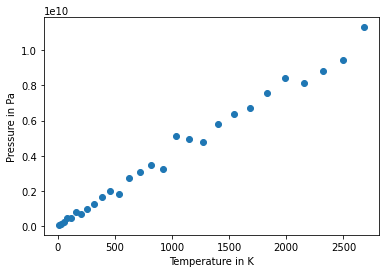

In [13]:
simulation.reset()
simulation.width.value=4000
simulation.generateParticles(n=200)

w = widgets.HBox([simulation.textPressure, simulation.textTemperature, simulation.textVolume])
display(w)
simulation.initialize()

pressure = np.array([])
temperature = np.array([])
for i in range(10,150,5):
    simulation.veloRatio.value=i/100
    sleep(3)
    temperature=np.append(temperature,simulation.textTemperature.value)
    pressure=np.append(pressure, simulation.textPressure.value)

simulation.stop()
plt.scatter(temperature,pressure)
plt.xlabel("Temperature in K")
plt.ylabel("Pressure in Pa")
plt.show() 

Der gezeigte Plot sieht sehr nach einer linearen Funktion aus. Dann muss gelten: $p = k_2(N,V) \cdot T$. Überprüfen wir dies mithilfe einer Regression:

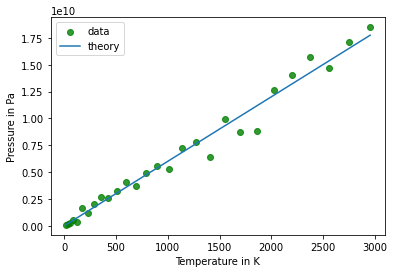

k2 = [6003759.88846294]


In [26]:
def linear(x,k2):
    return k2*x

k2, cov=curve_fit(linear,temperature,pressure,absolute_sigma=True)
plt.scatter(temperature, pressure, color="green", label="data", alpha=0.8)
plt.plot(temperature, linear(temperature, k2), color="tab:blue", label="theory")
plt.xlabel(f"Temperature in K")
plt.ylabel(f"Pressure in Pa")
plt.legend()
plt.show()
print(f"k2 = {k2}")

Wir können bestätigen, dass es sich um einen linearen Zusammenhang handelt. Das bedeutet mathematisch:<br><br>
$
\begin{align*}
&p = k_2(V,N) \cdot T\\
\Rightarrow& p \propto T \;\; \hbox{falls V,N konstant}
\end{align*}
$<br><br>
Somit stimmt auch das 2. Gay-Lussac'sche Gesetz!

<h4>"Messunsicherheit"</h4>
Auch wenn wir keine experimentellen Daten haben, scheint es so, als ob unsere berechneten Werte um die theoretischen Wert streuen. Das kommt vor allem durch die Definition und die Berechnung vom Druck. Während Temperatur und Volumen aufgrund ihrer Konstruktion und der Energieerhaltung ohne äußeren Einfluss konstant bleiben, ändert sich der Druck in jedem Zeitintervall dt, da dieser abhängig von den Wandstößen ist. Da die Teilchen sich zufällig bewegen, kollidieren zu unterschiedlichen Zeitintervallen unterschiedlich viele Teilchen. Genau dieser Fehler macht sich hier bemerkbar.<br>
Um diesen zu umgehen, gibt es die Möglichkeit, den Druck über eine gewisse Zeitspanne zu messen und den Mittelwert zu bilden. Das sorgt dafür, dass die Werte anscheinend konstant sind, es sollte aber nicht vernachlässigt werden, dass hier nur Mittelwerte gemessen werden, die eine gewisse Zeit brauchen, um sich neu einzustellen. 

<h4>ungewöhnlich Skaleneinheiten</h4>
Die Skaleneinheiten dieser Simulation sind sehr ungewöhnlich. Das Volumen hat Potenz $10^{-28}$, der Druck liegt im Bereich von $10^{10} Pa$. Einzig die Temperatur scheint bei halbwegs normalen Werten zu sein. Grund dafür sind die unverhältnismäßig kleinen Teilchen. Da in der Simulation Teilchen sowie Box dargestellt werden sollen, sind die Maße für unsere Box dementsprechend klein. Jetzt gibt es zwei Möglichkeiten. Entweder setzen wir die Teilchengeschwindigkeit auf normale Geschwindigkeiten (approx. $1000 \frac{m}{s}$) oder auf einem der Größe entsprechenden Wert (approx $1000\frac{pm}{s}$). Der erste Fall sorgt dafür, dass die Zeitintervalle sehr klein sein müssen, damit die Berechnungen genau bleiben, wodurch der Druck sehr groß wird. Dieser Fall wurde für unsere SImulation genommen. Der zweite Fall sorgt dafür, dass die Teilchengeschwindigkeit und damit auch die Temperatur  sehr klein werden.

<h4>allgemeines Gasgesetz</h4>

Mithilfe der beiden obigen Gesetze gilt: $\frac{p \cdot V}{T} = konst.$ für eine feste Menge an idealem Gas. Dies wollen wir kurz überprüfen. Dafür generieren wir erneut 200 Teilchen, starten die Simulation und variieren abwechselnd Volumen und Geschwindigkeit. Dabei wird Druck, Temperatur, Volumen und Zeit in vier verschiedenen Arrays gemessen und aufgezeichnet. In einem Scatterplot wird der Quotient $\frac{p \cdot V}{T}$ über die Zeit aufgetragen.

Canvas(height=300, width=1000)

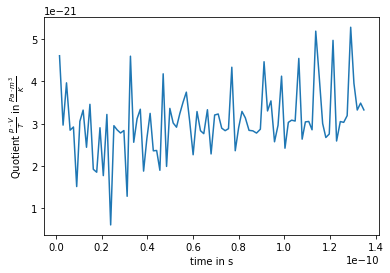

In [21]:
simulation.reset()
simulation.width.value=10000
simulation.generateParticles(n=200)

w = widgets.HBox([simulation.textPressure, simulation.textTemperature, simulation.textVolume])
display(w)
simulation.initialize()

time = np.array([])
pressure = np.array([])
temperature = np.array([])
volume = np.array([])

for i in range(0,9000,500):
    for j in range (1,102,25):
        simulation.width.value=10000-i
        simulation.veloRatio.value=j/100
        sleep(3)
        temperature=np.append(temperature,simulation.textTemperature.value)
        pressure=np.append(pressure, simulation.textPressure.value)
        volume=np.append(volume, simulation.textVolume.value)
        time=np.append(time, simulation.t)

simulation.stop()
plt.plot(time,pressure*volume/temperature)
plt.xlabel(r"time in s")
plt.ylabel(r"Quotient $\frac{p \cdot V}{T}$ in $\frac{Pa \cdot m^3}{K}$")
plt.show()

Es ist leicht zu erkennen, dass der Wert um eine Konstante schwankt, was unsere Theorie bestätigt.

<h4>ideales Gasgesetz</h4>

Um abschließend das ideale Gasgesetz numerisch zu beweisen, generieren wir 50 Teilchen und halten Volumen und Temperatur konstant. Indem wir jeweils nach einer Sekunde die Teilchenanzahl um 1 erhöhen und sie zusammen mit dem Druck in zwei Arrays aufzeichnen, können wir einen Scatterplot auftragen, um so den Zusammenhang zu finden.

Canvas(height=300, width=1000)

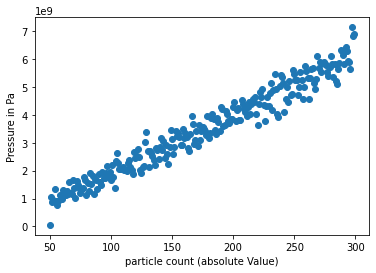

In [19]:
simulation.reset()
simulation.generateParticlesUniformly(n=50, v=1000)

w = widgets.HBox([simulation.textPressure, simulation.textTemperature,simulation.textVolume, simulation.textParticles])
display(w)
simulation.initialize()

pcount = np.array([])
pressure = np.array([])

for i in range(50,300,1):
    pcount = np.append(pcount, simulation.textParticles.value)
    pressure = np.append(pressure, simulation.textPressure.value)
    sleep(1)
    simulation.generateParticlesUniformly(n=1, v=1000)
    
plt.scatter(pcount,pressure)
plt.xlabel("particle count (absolute Value)")
plt.ylabel("Pressure in Pa")
plt.show()

Der gezeigte Plot sieht sehr nach einer linearen Funktion aus. Dann muss gelten: $p = k_3(T,V) \cdot N$. Überprüfen wir dies mithilfe einer Regression:

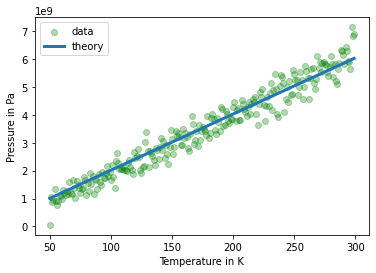

m = [20140617.91228646]


In [20]:
def linear(x,a):
    return a*x

m, cov=curve_fit(linear,pcount,pressure,absolute_sigma=True)
plt.scatter(pcount, pressure, color="green", label="data", alpha=0.3)
plt.plot(pcount, linear(pcount, m), color="tab:blue", label="theory", linewidth=3)
plt.xlabel(f"Temperature in K")
plt.ylabel(f"Pressure in Pa")
plt.legend()
plt.show()
print(f"m = {m}")

Wir können bestätigen, dass es sich um einen linearen Zusammenhang handelt. Das bedeutet mathematisch:<br><br>
$
\begin{align*}
&p = k_3(T,V) \cdot N\\
\Rightarrow& p \propto N \;\; \hbox{falls T,V konstant}
\end{align*}
$

Wir haben es geschafft, folgende drei Gleichungen numerisch zu prüfen:

<ol>
    <li>     $p \propto \frac{1}{V}$ für festes N, T</li>
    <li>     $p \propto T$ für festes N, V</li>
    <li>     $p \propto N$ für festes T, V </li>
</ol>
Das bedeutet, dass wir es geschafft haben, die ideale Gasgleichung anhand unseres Modelles herzuleiten!

<h3>interaktive Simulation</h3>

Zum Abschluss des Projekts hab ich eine kleine interakive Simulation erstellt. Dort gibt es folgende Einstellungsmöglichkeiten:

<ul>
    <li><i>+</i> add 10 Particles</li>
    <li><i>-</i> remove 10 Particles </li>
    <li><i>width (pm)</i> changes the width of the box</li>
    <li><i>Velocity</i> changes the velocity ratio (2 means 200%)</li>
    <li><i>start</i> starts the animation</li>
    <li><i>stop</i> stops the animation</li>
</ul>

Wenn die Druckanzeige zu sehr schwankt, dann in der Simulationsklasse die Länge des Impuls Arrays und damit die Länge des Durchschnittimpulses eingestellt werden. 

In [ ]:
simulation.reset()
simulation.impulse = np.zeros(300) #edit here if needed
simulation.interactive()

Feel free to explore!

<h2> Summary </h2>